<a href="https://colab.research.google.com/github/OlegV12/NaturalLangProcessing/blob/Lesson_7/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 8.2 MB 38.5 MB/s 


In [31]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=0868069ce7cdfea9d43edf25fee4c50008397afa42cbc1f4ff4f84306fe762ad
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from string import punctuation
from stop_words import get_stop_words
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt
from pymorphy2 import MorphAnalyzer

In [33]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [42]:

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [161]:
df = pd.read_excel('/gdrive/MyDrive/Colab Notebooks/NLP/data.xls')

In [162]:
df['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [163]:
my_dict = {1:0, 2:0, 4:1, 5:1}

In [164]:
df['label'] = df['Rating'].map(my_dict)

In [165]:
df.drop(df.loc[df['Rating']==3].index, inplace=True)

In [166]:
df.reset_index(inplace=True, drop=True)


In [169]:
df = df[['Content', 'label']]

In [170]:
df['label'].value_counts()

1.0    16724
0.0     3024
Name: label, dtype: int64

In [171]:
# variables
max_words = 3000
max_len = 20
num_classes = 1

# Training
epochs = 32
batch_size = 128
print_batch_n = 100

In [172]:
sw = set(get_stop_words("ru"))
puncts = set(punctuation)

In [173]:
morpher = MorphAnalyzer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "no", txt)
#     txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [174]:
from tqdm import tqdm 
tqdm.pandas()

df['feedback'] = df['Content'].progress_apply(preprocess_text)


100%|██████████| 19748/19748 [00:00<00:00, 28545.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [175]:
df.head()

,Content,label,feedback
0,It just works!,1.0,it just work
1,В целом удобноное приложение...из минусов хотя...,1.0,целом удобноное приложениеиз минусов хотят бол...
2,Отлично все,1.0,отлично
3,Стал зависать на 1% работы антивируса. Дальше ...,1.0,зависать 1 работы антивируса ранее пользовался...
4,"Очень удобно, работает быстро.",1.0,удобно работает быстро


In [176]:
train_corpus = " ".join(df["feedback"])
train_corpus = train_corpus.lower()

In [177]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['it', 'just', 'work', 'целом', 'удобноное']

In [178]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [179]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [180]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работает',
 'удобное',
 'отлично',
 'нравится',
 'отличное',
 'супер',
 'быстро',
 'хорошее']

In [181]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
len(vocabulary)

2999

In [182]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [183]:
%%time
df_train = np.asarray([text_to_sequence(text, max_len) for text in df["feedback"]])

CPU times: user 2.7 s, sys: 6.75 ms, total: 2.71 s
Wall time: 3.08 s


In [184]:
x_train, x_test, y_train, y_test = train_test_split(df_train, df['label'], random_state=42, train_size=0.8, stratify=df['label'])

In [207]:
def weighted_binary_cross_entropy(output, target, weights=(1, 0.18)):
        
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output + np.finfo(float).eps))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [186]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [209]:
def my_train(model, th=0.5):
    
    model = model.to(device)
    model.train()
    th = 0.5

    train_loss_history = []
    test_loss_history = []


    for epoch in range(epochs):  
        running_items, running_right,  train_target_true, train_target_pred = 0.0, 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обнуляем градиент
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = weighted_binary_cross_entropy(outputs, labels.float().view(-1, 1), (1, 0.18))
            loss.backward()
            optimizer.step()

            # подсчет ошибки на обучении
            loss = loss.item()
            running_items += len(labels)
            # подсчет метрики на обучении
            pred_labels = torch.squeeze((outputs > th).int())
            running_right += (labels == pred_labels).sum()
            
            train_target_true += torch.sum(labels == 1).float()
            train_target_pred += ((labels == 1) & (pred_labels==1)).sum()

        # выводим статистику о процессе обучения
        model.eval()

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                f'Step [{i + 1}/{len(train_loader)}]. ' \
                f'Loss: {loss:.3f}. ' \
                f'Recall: {train_target_pred/train_target_true:.3f}. ' \
                f'Acc: {running_right / running_items:.3f}', end='. ')
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        train_loss_history.append(loss)

            # выводим статистику на тестовых данных
        test_running_right, test_running_total, test_loss,  = 0.0, 0.0, 0.0, 
        target_true, target_pred, train_target_true, train_target_pred = 0.0, 0.0, 0.0, 0.0
        for j, data in enumerate(val_loader):

            test_labels = data[1].to(device)
            test_outputs = model(data[0].to(device))

            target_true += torch.sum(test_labels == 1).float()


            # подсчет ошибки на тесте
            test_loss = weighted_binary_cross_entropy(test_outputs, test_labels.float().view(-1, 1), (1, 0.18))
            # подсчет метрики на тесте
            test_running_total += len(data[1])
            pred_test_labels = torch.squeeze((test_outputs > th).int())
            target_pred += ((test_labels==1) & (pred_test_labels==1)).sum()
            test_running_right += (test_labels == pred_test_labels).sum()

        test_loss_history.append(test_loss.item())
        print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test recall {target_pred/target_true:.3f}')
#         target_true, target_pred, test_running_right = 0.0, 0.0, 0.0
        model.train()

    print('Training is finished!')


    plt.title('Loss history')
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(train_loss_history, label='train')
    plt.plot(test_loss_history, label='test')
    plt.legend();

In [201]:
class Net(nn.Module):
    def __init__(self, vocab_size=3000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)      
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [202]:
train_dataset = DataWrapper(x_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




val_dataset = DataWrapper(x_test, y_test.values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [203]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([128, 20])
torch.Size([128])
tensor(1)


In [210]:
model = Net()

In [211]:
device = 'cpu'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/32]. Step [124/124]. Loss: 0.138. Recall: 0.825. Acc: 0.806. Test loss: 0.147. Test acc: 0.809. Test recall 0.819
Epoch [2/32]. Step [124/124]. Loss: 0.167. Recall: 0.819. Acc: 0.818. Test loss: 0.150. Test acc: 0.787. Test recall 0.776
Epoch [3/32]. Step [124/124]. Loss: 0.094. Recall: 0.827. Acc: 0.831. Test loss: 0.103. Test acc: 0.818. Test recall 0.813
Epoch [4/32]. Step [124/124]. Loss: 0.088. Recall: 0.848. Acc: 0.852. Test loss: 0.081. Test acc: 0.855. Test recall 0.859
Epoch [5/32]. Step [124/124]. Loss: 0.096. Recall: 0.862. Acc: 0.867. Test loss: 0.075. Test acc: 0.863. Test recall 0.865
Epoch [6/32]. Step [124/124]. Loss: 0.057. Recall: 0.875. Acc: 0.879. Test loss: 0.077. Test acc: 0.856. Test recall 0.854
Epoch [7/32]. Step [124/124]. Loss: 0.082. Recall: 0.883. Acc: 0.888. Test loss: 0.082. Test acc: 0.871. Test recall 0.874
Epoch [8/32]. Step [124/124]. Loss: 0.071. Recall: 0.887. Acc: 0.892. Test loss: 0.103. Test acc: 0.888. Test recall 0.900
Epoch [9/32]. St

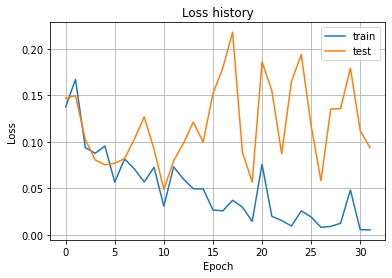

In [212]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
my_train(model)

In [ ]:
model_1 = gensim.models.KeyedVectors.load_word2vec_format('ruscorpora_1_300_10.bin.gz', binary=True)
for n in model.most_similar(positive=[u'пожар_NOUN']):
    print n[0], n[1]

In [213]:
import gensim

In [214]:

model_gen = gensim.models.KeyedVectors.load_word2vec_format('/gdrive/MyDrive/Colab Notebooks/NLP/model.txt')
weights = torch.FloatTensor(model_gen.vectors) 

In [215]:
# model_bin = gensim.models.KeyedVectors.load_word2vec_format('/gdrive/MyDrive/Colab Notebooks/NLP/model.bin', binary=True)

In [216]:
embedding = nn.Embedding.from_pretrained(weights)

In [229]:
class Pretrained_Net(nn.Module):
    def __init__(self, vocab_size=3000, embedding_dim=300, out_channel=300, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)      
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [230]:
pretraind_model = Pretrained_Net()

In [231]:
pretraind_model.embedding.weight.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/32]. Step [124/124]. Loss: 0.128. Recall: 0.818. Acc: 0.809. Test loss: 0.112. Test acc: 0.791. Test recall 0.782
Epoch [2/32]. Step [124/124]. Loss: 0.056. Recall: 0.837. Acc: 0.841. Test loss: 0.103. Test acc: 0.848. Test recall 0.845
Epoch [3/32]. Step [124/124]. Loss: 0.056. Recall: 0.869. Acc: 0.873. Test loss: 0.102. Test acc: 0.871. Test recall 0.871
Epoch [4/32]. Step [124/124]. Loss: 0.088. Recall: 0.895. Acc: 0.899. Test loss: 0.132. Test acc: 0.874. Test recall 0.876
Epoch [5/32]. Step [124/124]. Loss: 0.030. Recall: 0.913. Acc: 0.916. Test loss: 0.071. Test acc: 0.888. Test recall 0.901
Epoch [6/32]. Step [124/124]. Loss: 0.047. Recall: 0.927. Acc: 0.929. Test loss: 0.105. Test acc: 0.877. Test recall 0.880
Epoch [7/32]. Step [124/124]. Loss: 0.034. Recall: 0.937. Acc: 0.939. Test loss: 0.094. Test acc: 0.890. Test recall 0.906
Epoch [8/32]. Step [124/124]. Loss: 0.036. Recall: 0.953. Acc: 0.954. Test loss: 0.060. Test acc: 0.882. Test recall 0.889
Epoch [9/32]. St

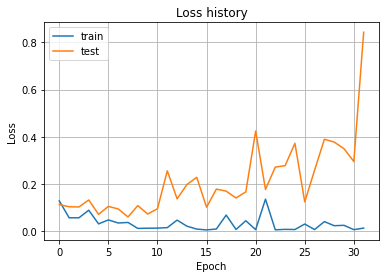

In [232]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pretraind_model.parameters()), lr=0.0001)
my_train(pretraind_model)

Достаточно сложено судить о качестве моделей из-зи большого дисбаланса классов. На графиках видно, что модель с предобученным эмбедингом в конце "разошлась". Модель без предобучения более стабильна. 